# Comparative Study of Regression Models for Seoul Bike Sharing Demand
### Name: Jaime Pantoja
 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model


## Data Preprocessing - Date

In [2]:
# Load the data from the source file

data = pd.read_csv("SeoulBikeData.csv", encoding='cp1252')

# Check for null or empty values in the DataFrame

print (data.isnull().sum())


Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64


Check the features' data types to understand the data structure and formats.
The Date feature is being considered as an Object, it needs to be formatted as Date to expand the analysis.

In [3]:
print(data.dtypes)

Date                          object
Rented Bike Count              int64
Hour                           int64
Temperature(°C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(°C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object
dtype: object


In [4]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

'''
After changing the Date format other features can be extracted, such as day, month and year.
Additionally, the date column can be dropped.
'''

data['day'] = data['Date'].dt.day_of_week
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year
data.drop(columns=['Date'], inplace=True)
data.head(1)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,day,month,year
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,4,12,2017


## Data Exploration - Cleaning

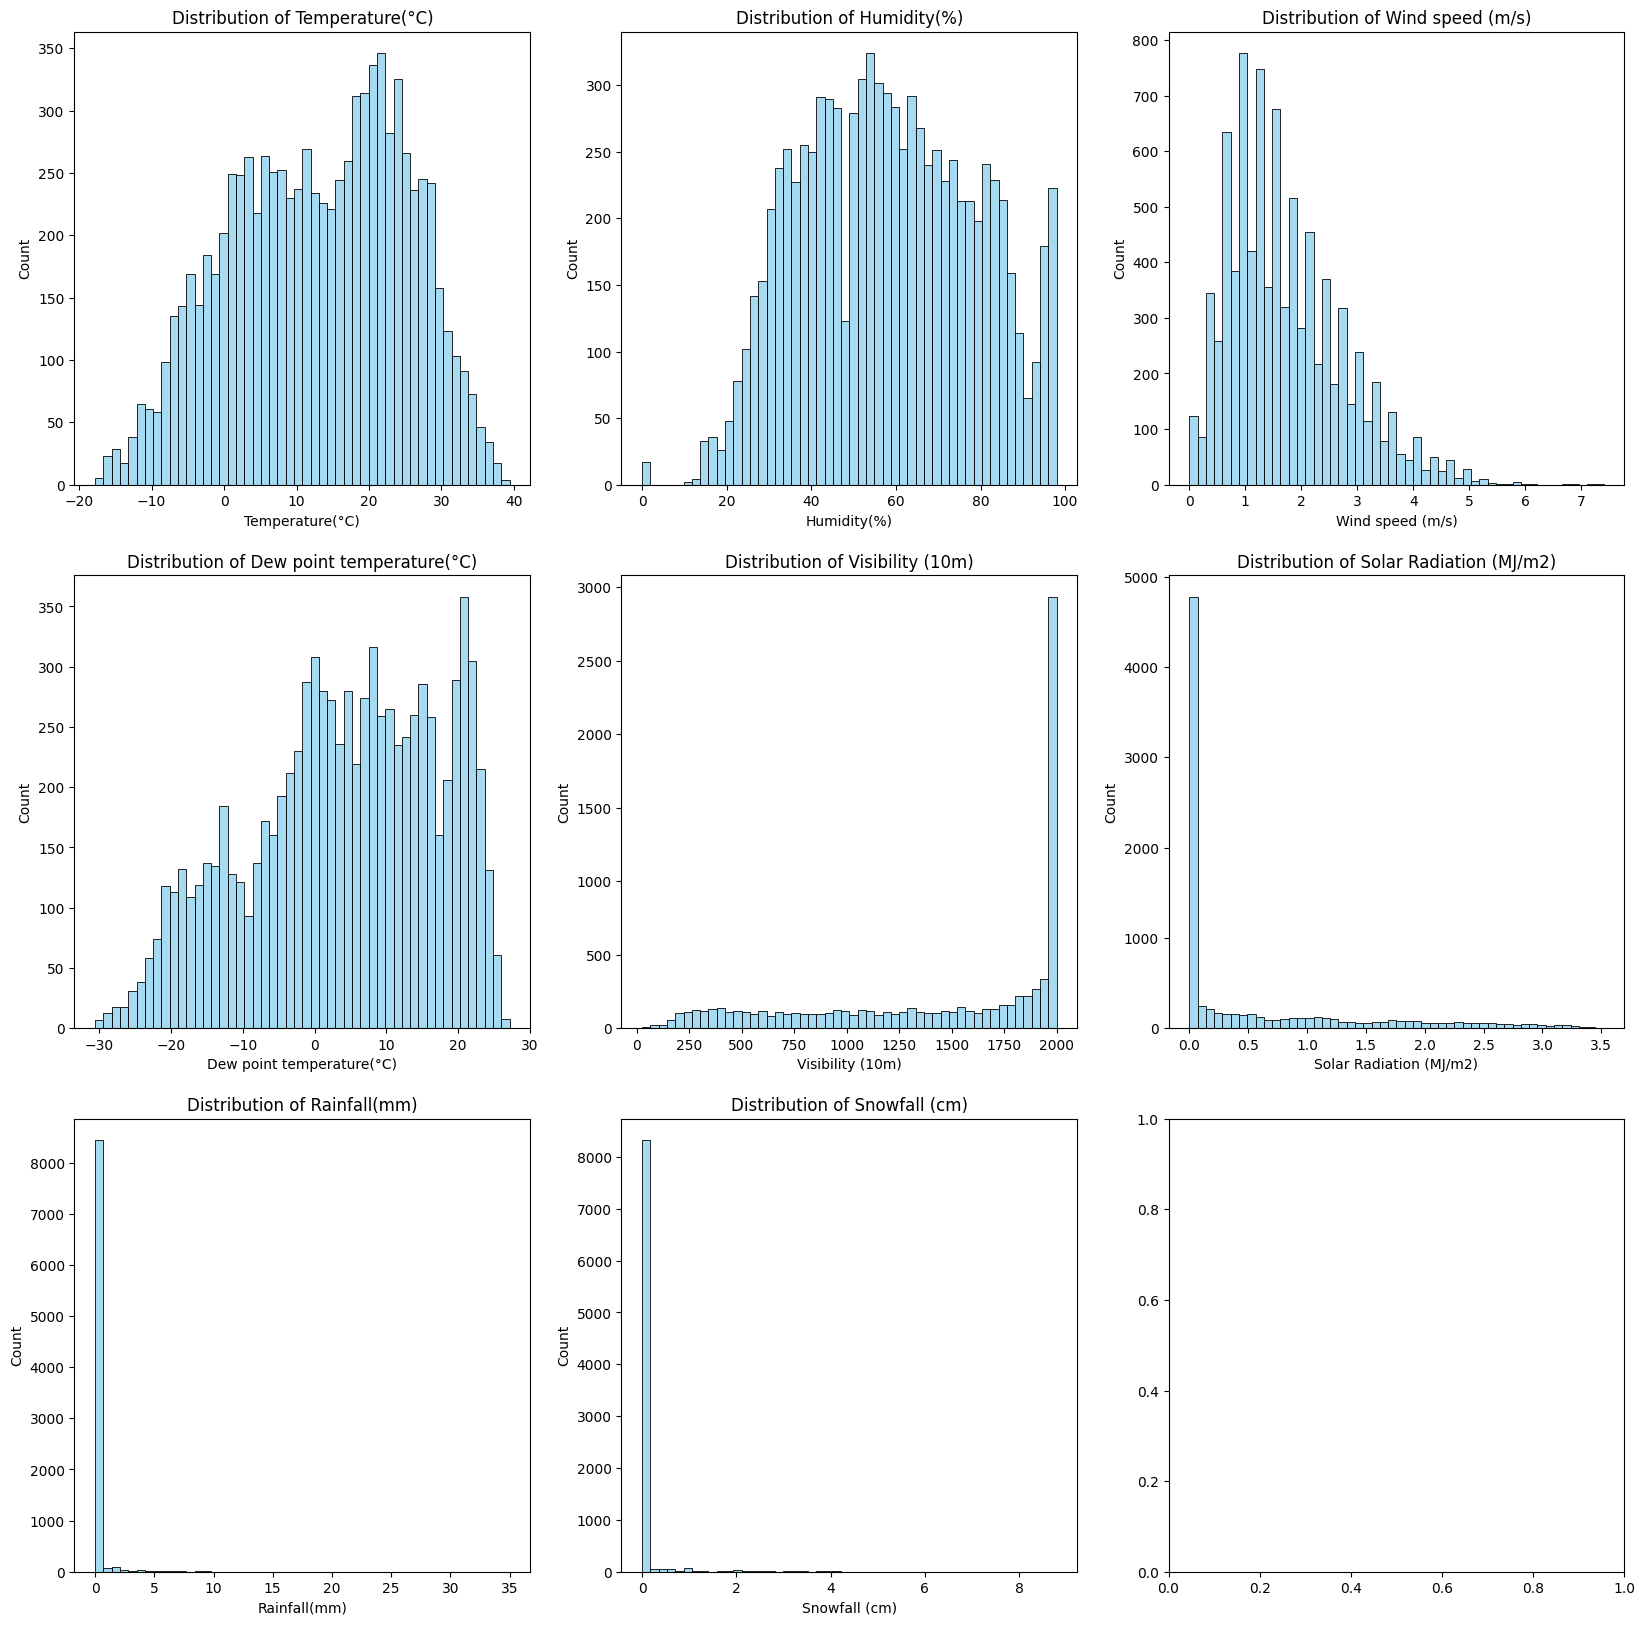

In [5]:


conditions = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Dew point temperature(°C)',
              'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
              ]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
axes = axes.flatten()
    
for i, feature in enumerate(conditions): 
    sns.histplot(data[feature], bins=50, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {feature}') 
    axes[i].set_xlabel(feature) 
    axes[i].set_ylabel('Count')

### Combined Histogram and Boxplot

Exploring histograms enable to capture the distributions' shapes and insights about 
features with similar behaviour. However, some features need to be considered in regards to its own nature. For instance,
the visibility histogram distribution shows that most of the observations fall into the 2000 bin,
meaning the visibility conditions for when the bikes where rented was optimal for a considerable 
part of the observations.

In the same way, the solar radiation distribution indicates most of the observations fall
within a value of zero, meaning no solar energy reached the specific location. This behaviour
can result as a consequence of the time of the day, for instance, during night times the 
solar radiation will be zero.

Similar, observations occur with Snowfall and Rainfall where most of the records are within the 
bin of zero. In conslusion, these distributions need to be considered within the context of the problem
to be analyzed.


Boxplots is another way to portray the features' beahviour, in regards to its distribution 
and indentifying outliers. It is important to mention that outliers can influence the model's learning process
and reduce its predictive accuracy. For instance, extreme conditions of rain, snow, or radiation might not be 
representative and the model wont be able to generalize properly.

The following code shows how to create a histogram with a boxplot graph in tha same chart.

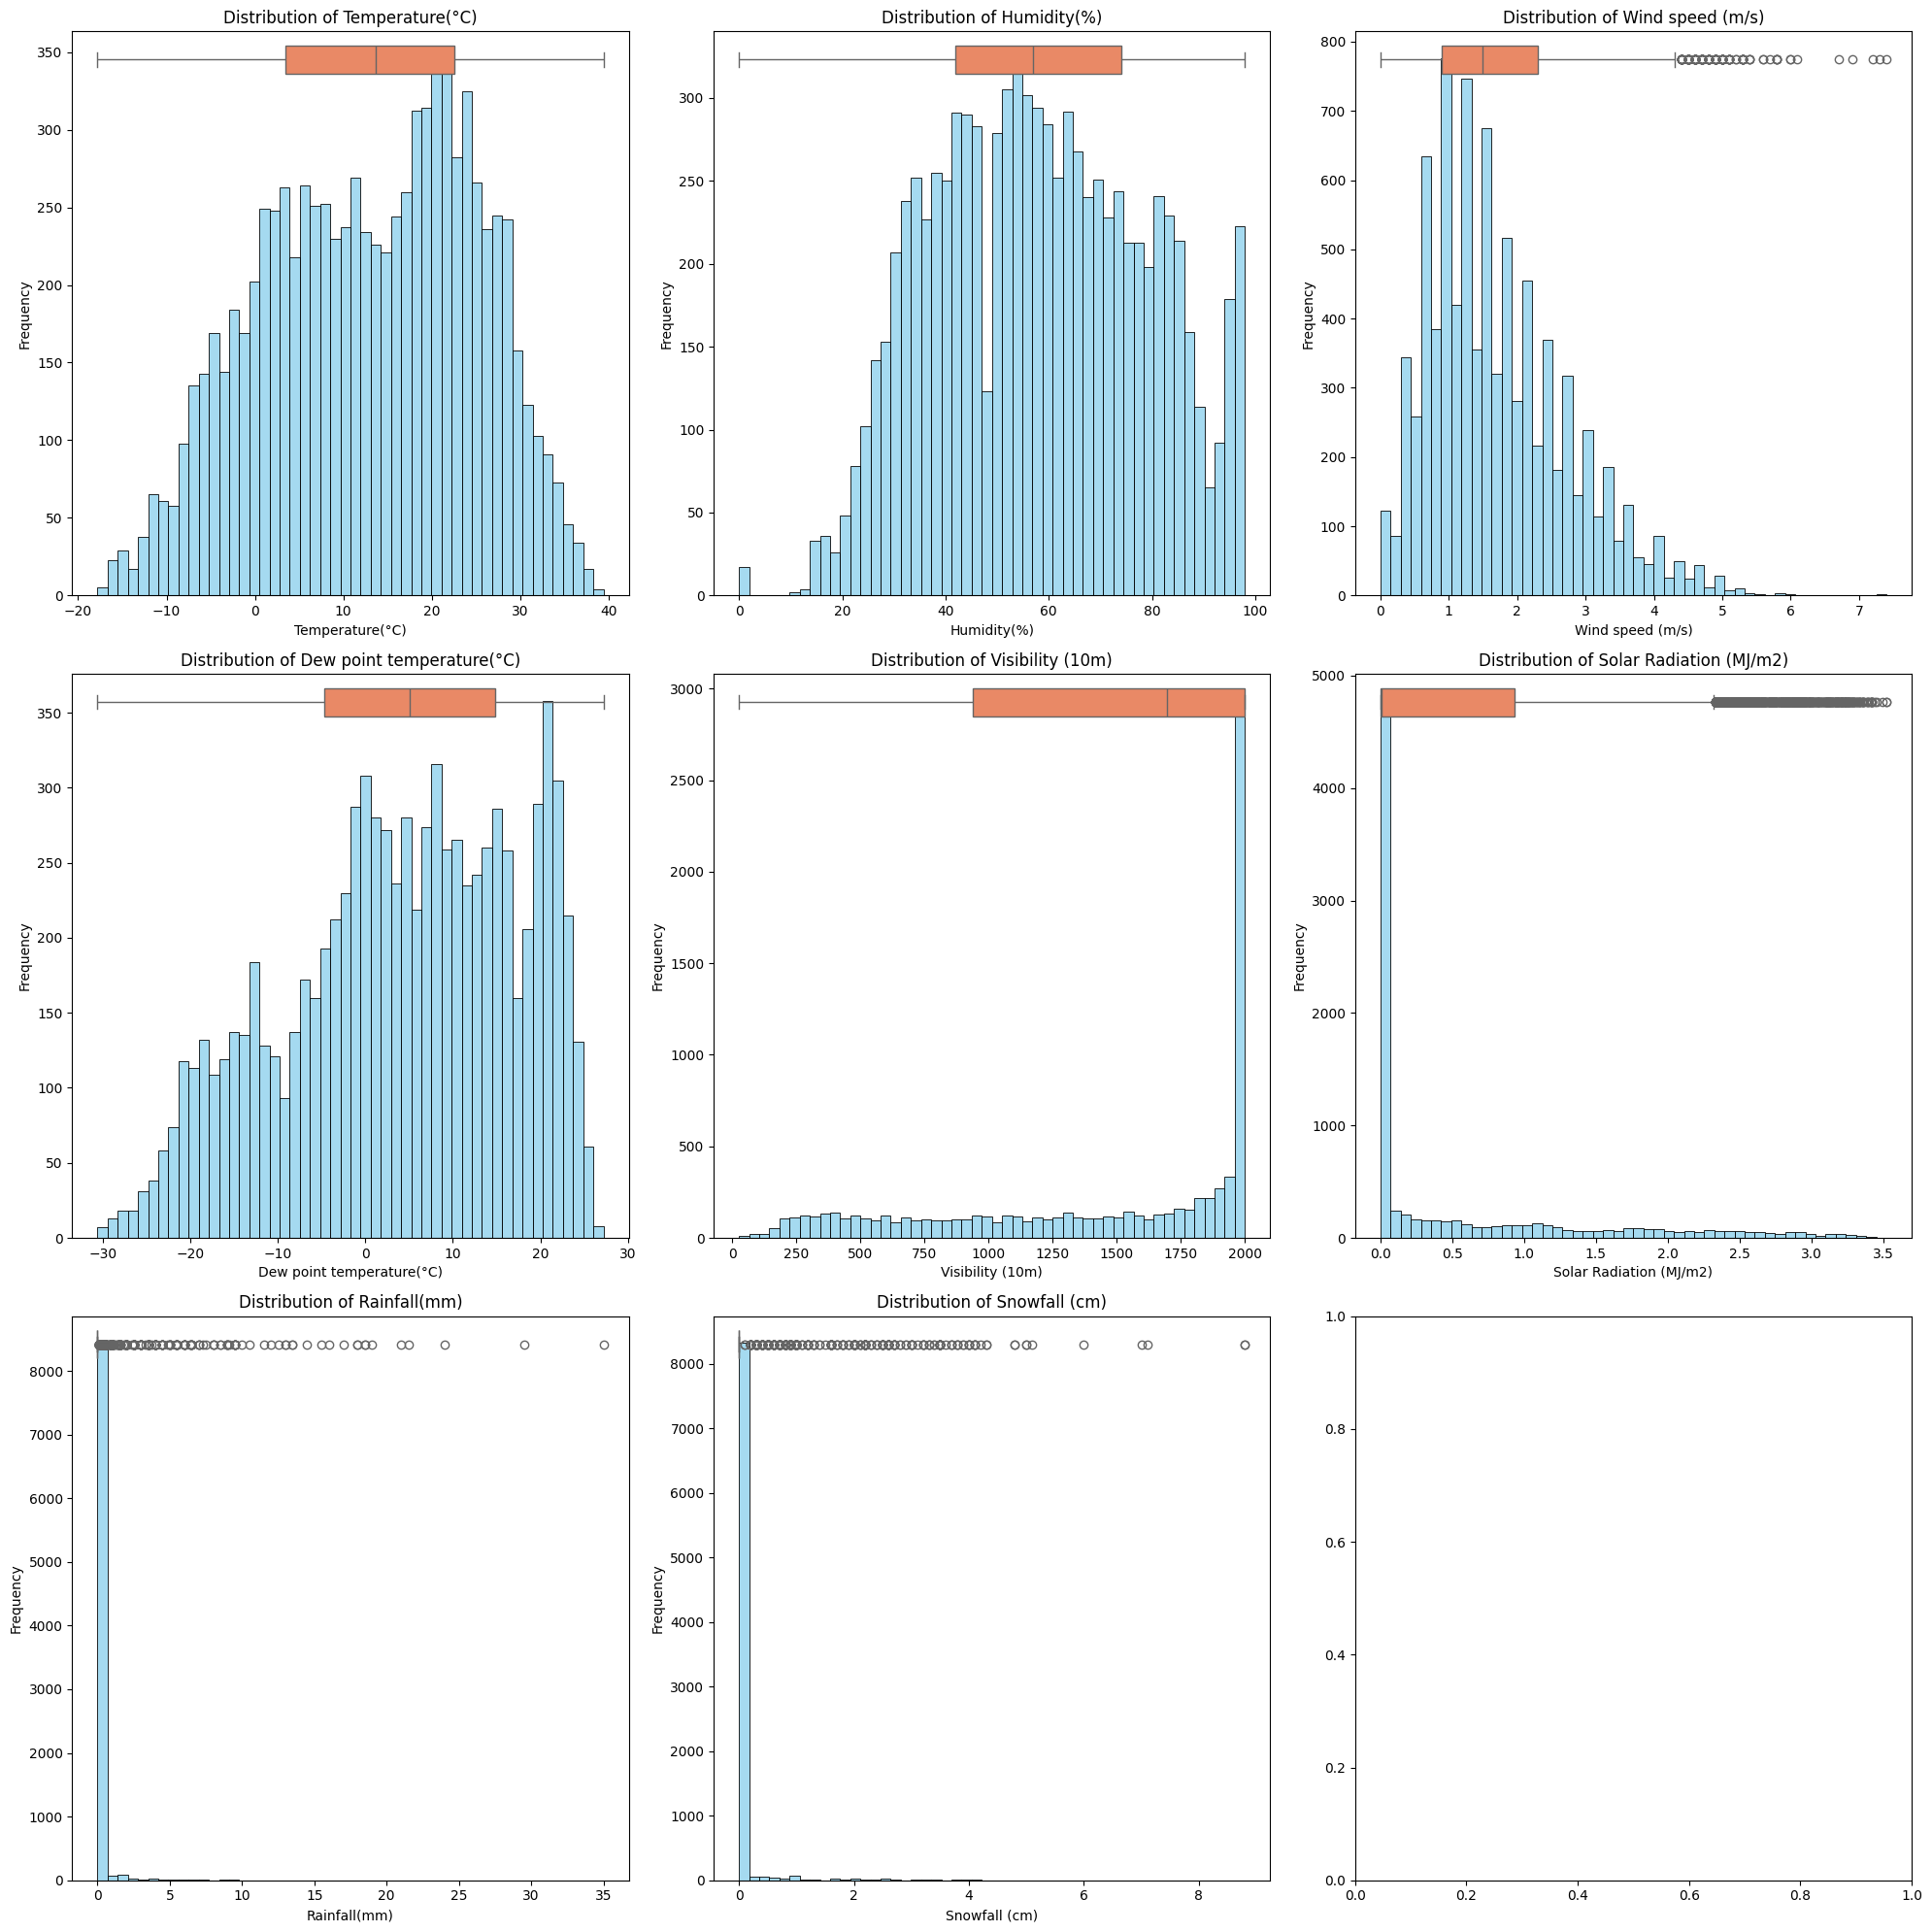

In [6]:
conditions = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Dew point temperature(°C)',
              'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
axes = axes.flatten()

for i, feature in enumerate(conditions):
    # Create two y-axis sections: one for the histogram, one for the boxplot
    divider = 0.1  # Fraction of the plot reserved for the boxplot

    # Create a histogram
    sns.histplot(data[feature], bins=50, ax=axes[i], kde=False, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

    # Get the data range for boxplot placement
    xmin, xmax = axes[i].get_xlim()

    # Add a boxplot on top of the histogram
    boxplot_ax = axes[i].inset_axes([0, 1 - divider, 1, divider])  # Position boxplot above histogram
    sns.boxplot(x=data[feature], ax=boxplot_ax, color='coral', width=0.5)
    boxplot_ax.set_xlim(xmin, xmax)  # Ensure the boxplot aligns with the histogram
    boxplot_ax.axis('off')  # Remove axis for the boxplot to avoid clutter

plt.tight_layout()
plt.show()

In [7]:
'''
The following function and code iterates through the selected columns 
to iterate and remove outliers according to the interquartile range technique
'''

def remove_outliers_iqr(data, feature):
  Q1 = data[feature].quantile(0.25)
  Q3 = data[feature].quantile(0.75)
  IQR = Q3 - Q1

  # Define bounds to identify outliers
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Filter out outliers
  data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]
  return data

# Apply the function to each feature
for feature in ['Wind speed (m/s)','Solar Radiation (MJ/m2)']:   # ,'Rainfall(mm)', 'Snowfall (cm)'
  data = remove_outliers_iqr(data, feature) 
  
print(data.shape[0])

7917


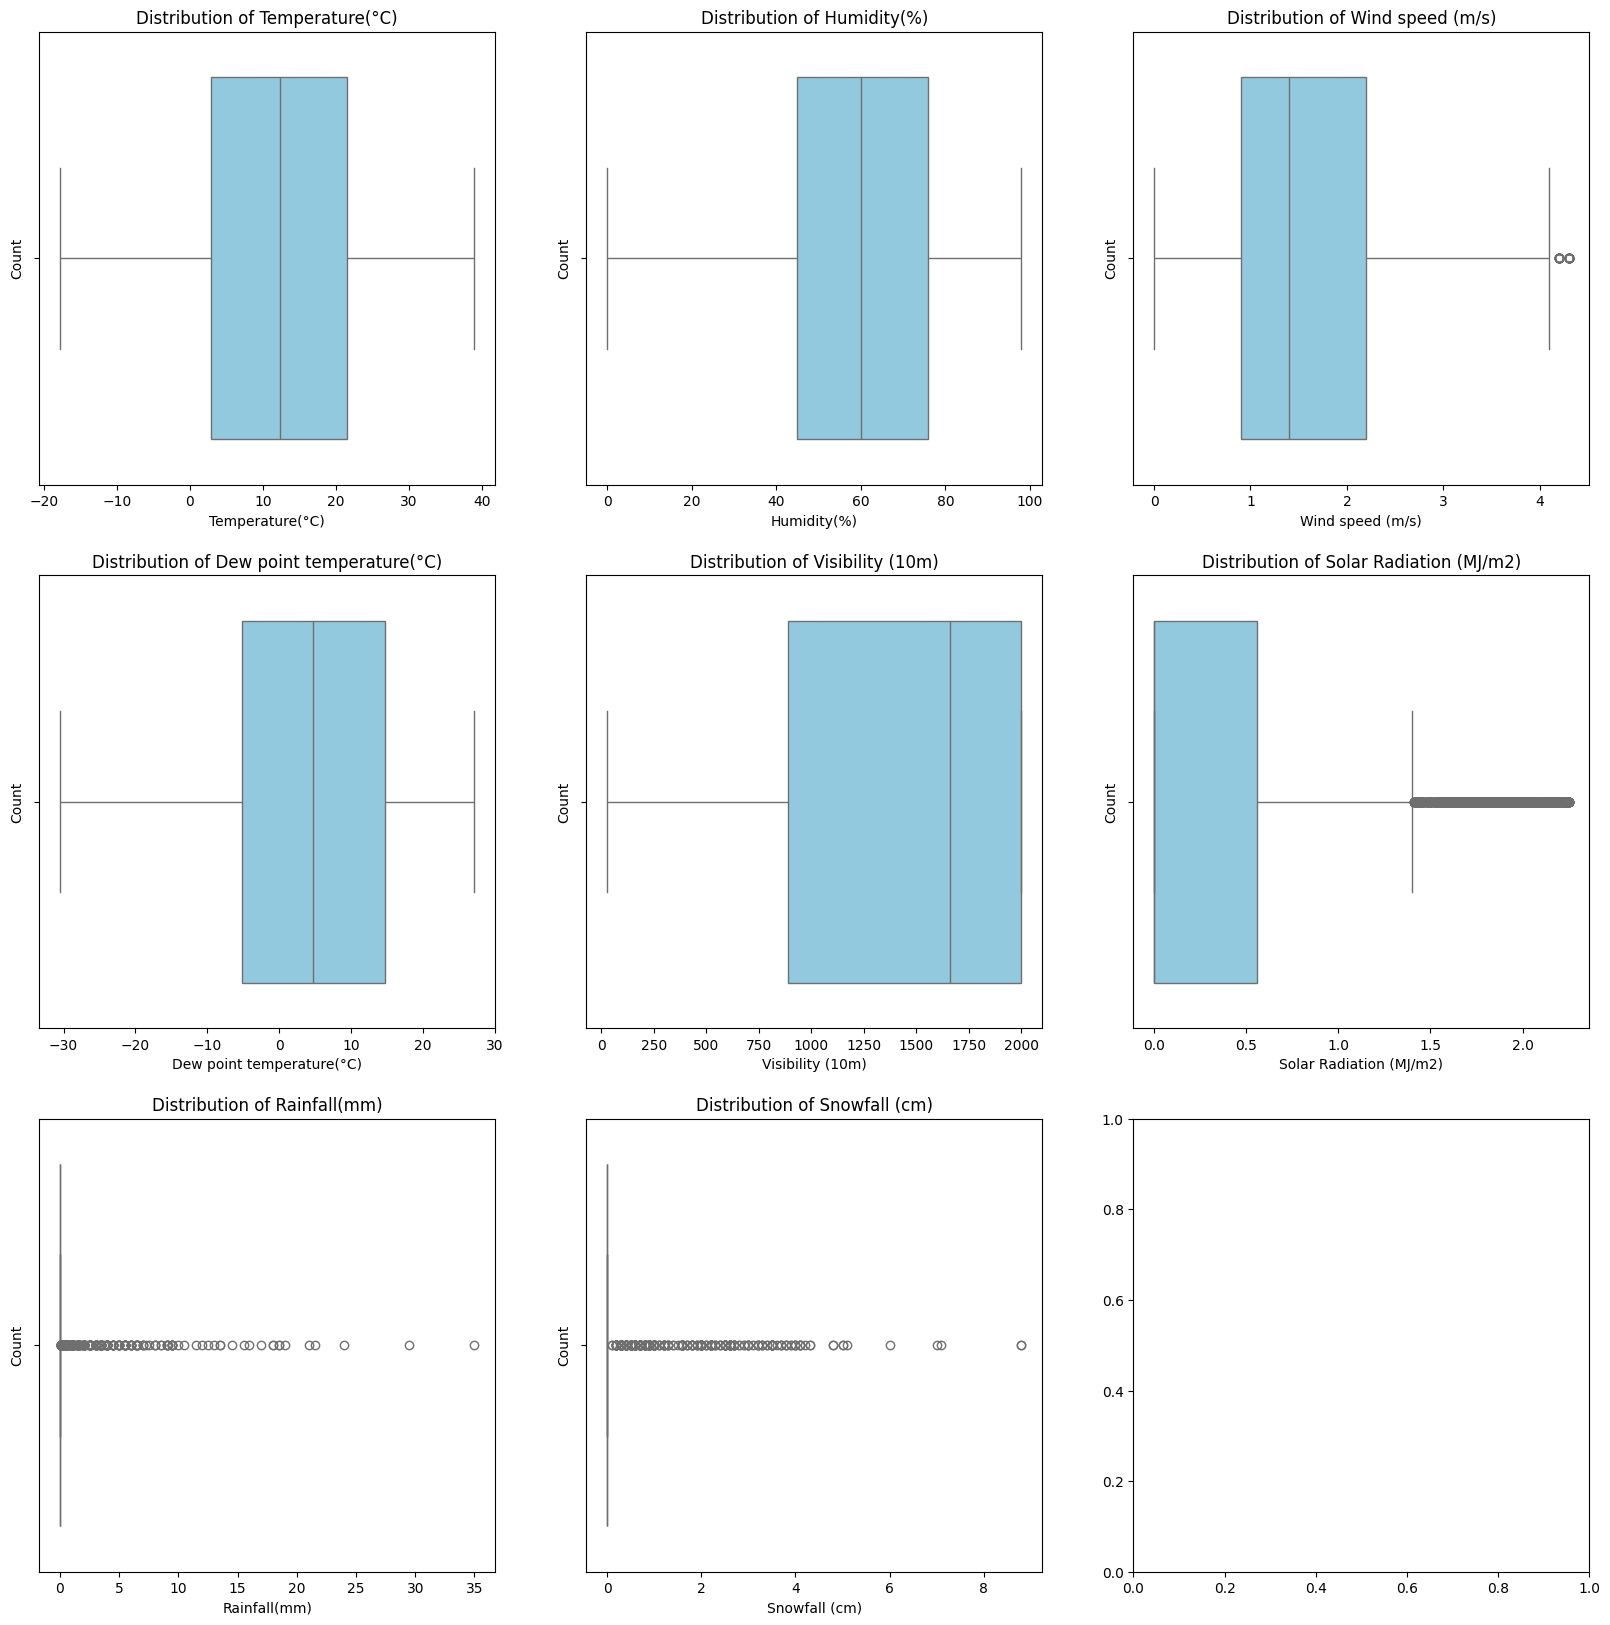

In [8]:
'''
After filtering the outliers, the boxplots for wind speed and solar radiation exhibit significant changes,
displaying fewer outlier values. This adjustment provides a clearer view of the underlying data distribution, 
allowing for more accurate and meaningful analysis.
'''

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
axes = axes.flatten()
    
for i, feature in enumerate(conditions): 
    sns.boxplot(x=data[feature], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {feature}') 
    axes[i].set_xlabel(feature) 
    axes[i].set_ylabel('Count')

### Features Correlation

Features correlation is another aspect to consider. Highly correlated features can introduce redundancy 
to the model leading to a poor generalization and decreasing its predictive value. There are different approaches 
for handling this dimensionality reduction, such as feature elimination, feature combination, or 
principal component analysys (PCA).

This workbook will plot the correlations and apply feaature elimination based on highly correlated elements by using a 
correlation matrix.

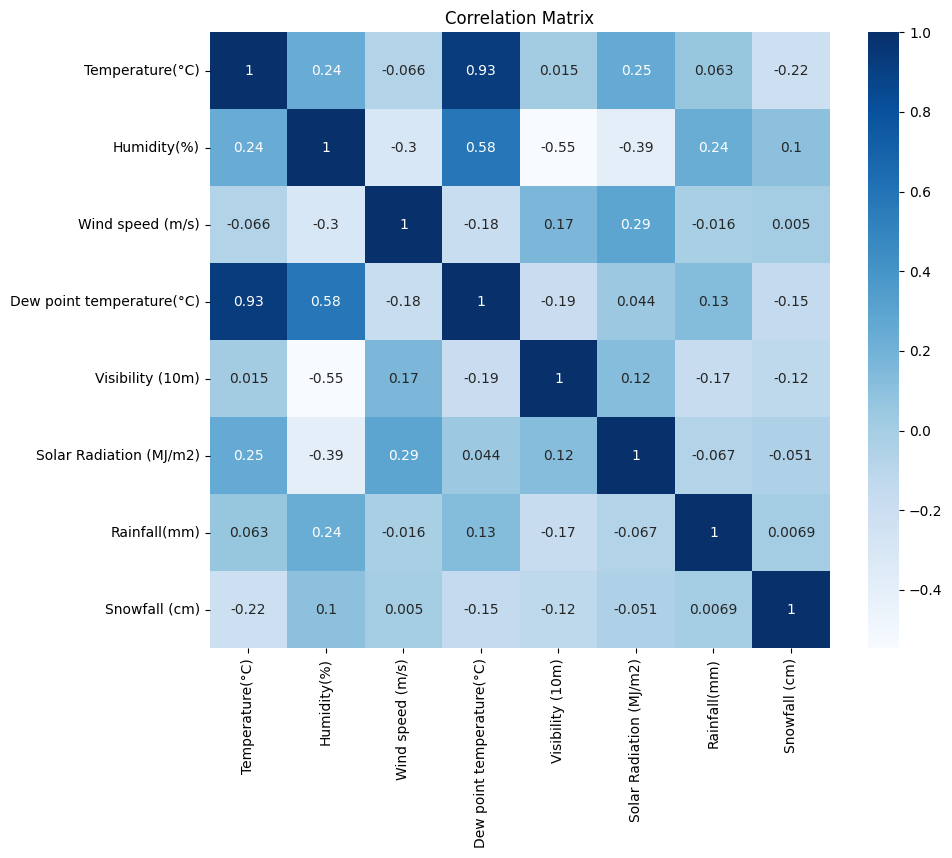

In [9]:
data_matrix = data[conditions]
# Calculate the correlation matrix
corr_matrix = data_matrix.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()


In [10]:
'''After running the matrix there is an evident high correlation between Temperature and Dew Point Temperature.
In this order of ideas, following the feature elimination the second one is dropped from the dataframe'''


data.drop(columns=['Dew point temperature(°C)'], inplace=True)



# Feature Engineering

After exploring the data, cleaning outliers and eliminating highly correlated features, it is time to one-hot encoding and feature scaling.

In [11]:
# Group the features by numerical and categorial

categorical_features = ['Seasons', 'Holiday', 'Functioning Day']

numerical_features = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
                      'Visibility (10m)','Solar Radiation (MJ/m2)', 'Rainfall(mm)', 
                      'Snowfall (cm)', 'day', 'month', 'year']

'''
It is important to mention that 'day', 'month', 'year', and 'hour' can be considered categorical features. 
However, in this context, they will be treated as numerical features. This classification is made to streamline 
the data processing steps before training the regression models. 
Treating these time-related features numerically allows for better handling in the modeling process, 
enabling more effective analysis and model performance.
'''

"\nIt is important to mention that 'day', 'month', 'year', and 'hour' can be considered categorical features. \nHowever, in this context, they will be treated as numerical features. This classification is made to streamline \nthe data processing steps before training the regression models. \nTreating these time-related features numerically allows for better handling in the modeling process, \nenabling more effective analysis and model performance.\n"

In [12]:
# Separate features and target
X = data.drop(columns=['Rented Bike Count']) # Features
y = data[['Rented Bike Count']] # Target

# Scale y
scaler_y= MinMaxScaler()
y_scaled = pd.DataFrame(scaler_y.fit_transform(y), columns=['Rented Bike Count'], index=y.index)

### Normalize Numerical Data

In [13]:
scaler = MinMaxScaler()  # Change to StandardScaler() if needed

# Fit and transform only the numerical features
X[numerical_features] = scaler.fit_transform(X[numerical_features])

X.head(1)

,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,day,month,year
0,0.0,0.221831,0.377551,0.511628,1.0,0.0,0.0,0.0,Winter,No Holiday,Yes,0.666667,1.0,0.0


### One-Hot Encode

In [14]:
encoder = OneHotEncoder(sparse_output=False, drop='first')  # `drop='first'` for avoiding multicollinearity
encoded_cats = encoder.fit_transform(X[categorical_features])

# Convert the encoded features to a DataFrame for easier handling
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

# Reset index to align with X
encoded_cats_df.index = X.index

print(encoded_cats_df.head(2))

   Seasons_Spring  Seasons_Summer  Seasons_Winter  Holiday_No Holiday  \
0             0.0             0.0             1.0                 1.0   
1             0.0             0.0             1.0                 1.0   

   Functioning Day_Yes  
0                  1.0  
1                  1.0  


In [15]:
print(X.columns)

Index(['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)',
       'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day', 'day',
       'month', 'year'],
      dtype='object')


### Combine Transformed Features

In [16]:
# Drop original categorical columns from X
X = X.drop(columns=categorical_features)

# Concatenate the normalized numerical features and encoded categorical features
X_transformed = pd.concat([X, encoded_cats_df], axis=1)

'''X_transformed is the fully preprocessed feature set, ready for model training'''

X_transformed.head(2)

,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),day,month,year,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Functioning Day_Yes
0,0.000000,0.221831,0.377551,0.511628,1.0,0.0,0.0,0.0,0.666667,1.0,0.0,0.0,0.0,1.0,1.0,1.0
1,0.043478,0.216549,0.387755,0.186047,1.0,0.0,0.0,0.0,0.666667,1.0,0.0,0.0,0.0,1.0,1.0,1.0


In [17]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_scaled, test_size=0.2, random_state=42)

# Train and Test the Models

### Linear Regression

In [18]:
# Create a results dictionary to make the models comparable

results = {}

C:\Users\jaime\AppData\Local\Temp\ipykernel_18948\3516068625.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients_df, palette='coolwarm')


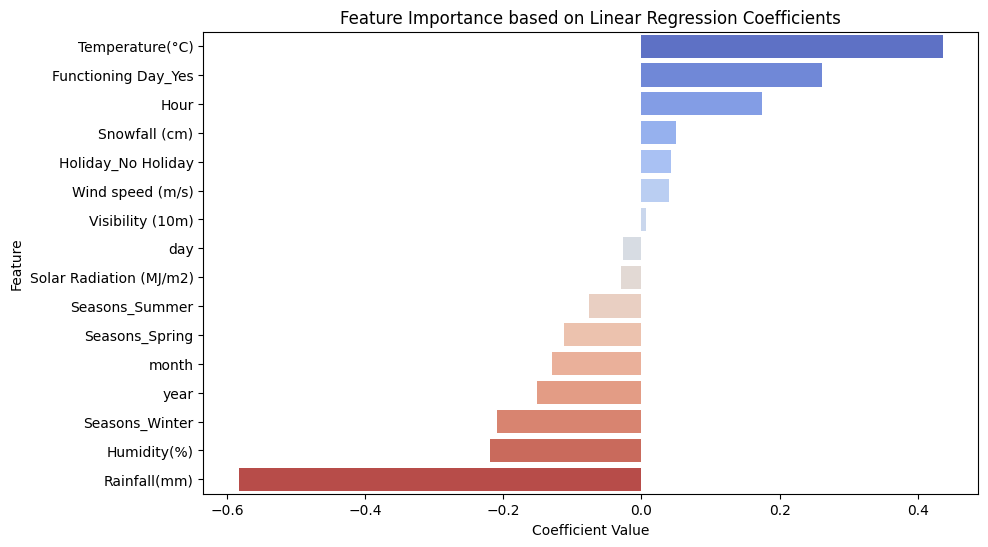

In [19]:
featuresLinear = X_train.columns.tolist()
# Initialize and train the linear regression model
modelLinear = LinearRegression()
modelLinear.fit(X_train, y_train)

# Extract coefficients
coefficients = modelLinear.coef_
intercept = modelLinear.intercept_

# Ensure coefficients are 1-dimensional
coefficients = coefficients.flatten()

# Create a DataFrame for coefficients
coefficients_df = pd.DataFrame({
    'Feature': featuresLinear,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df, palette='coolwarm')
plt.title('Feature Importance based on Linear Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Predict on the test set
y_pred = modelLinear.predict(X_test)
    
# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Store the result
results['Linear Regression'] = mse

### Decision Tree

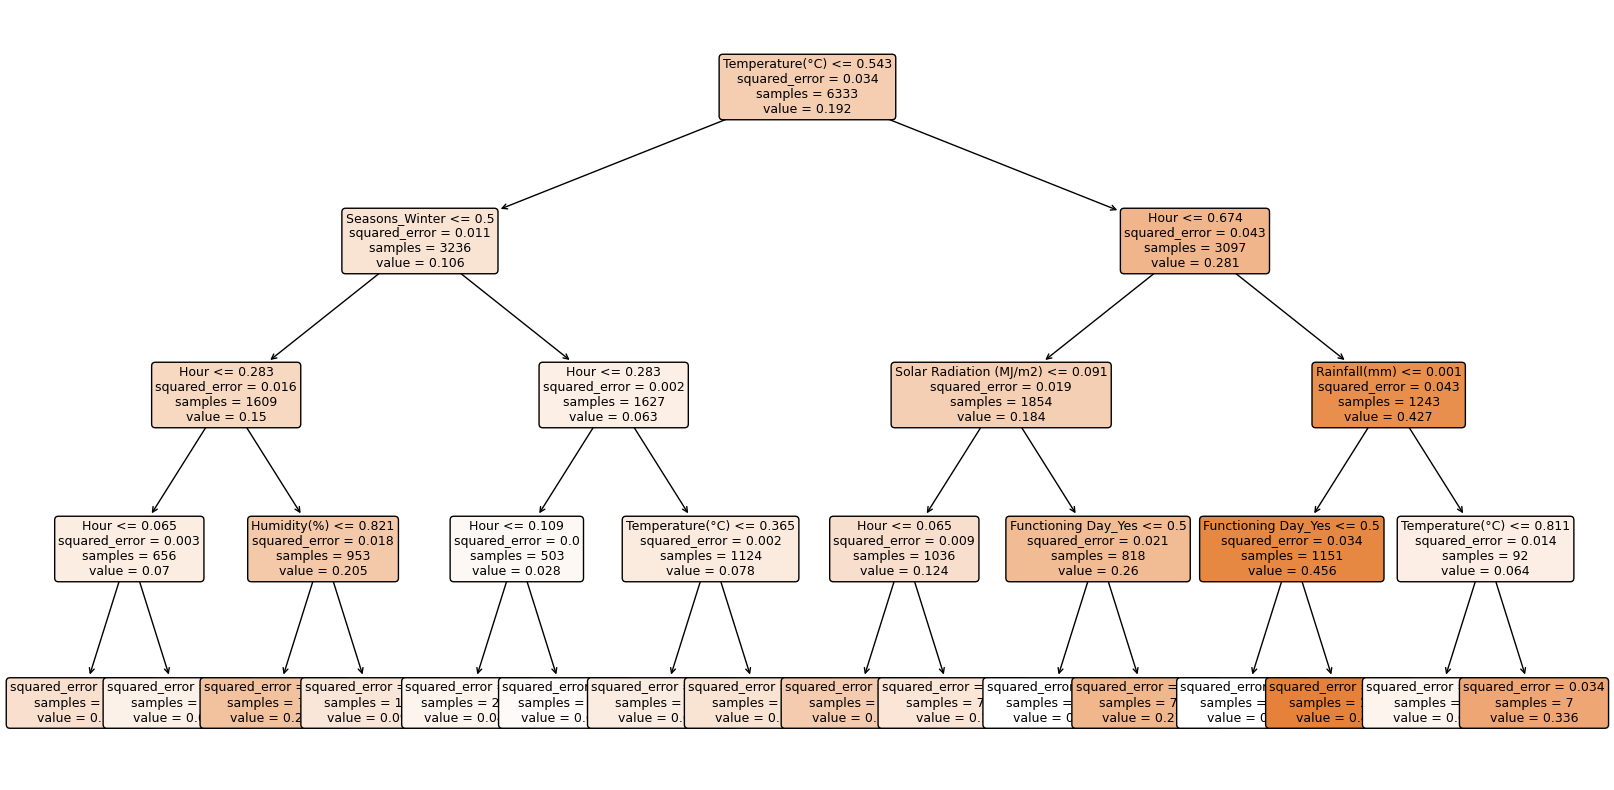

In [20]:
features = X_train.columns.tolist()
target = 'Rented Bike Count'

# Initialize and train the model
modelTree = DecisionTreeRegressor(max_depth=4)
modelTree.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(modelTree, feature_names=features, filled=True, rounded=True, fontsize=9)
plt.show()

# Predict on the test set
y_pred = modelTree.predict(X_test)
    
# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Store the result
results['Decision Tree'] = mse


C:\Users\jaime\AppData\Local\Temp\ipykernel_18948\3611634969.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')


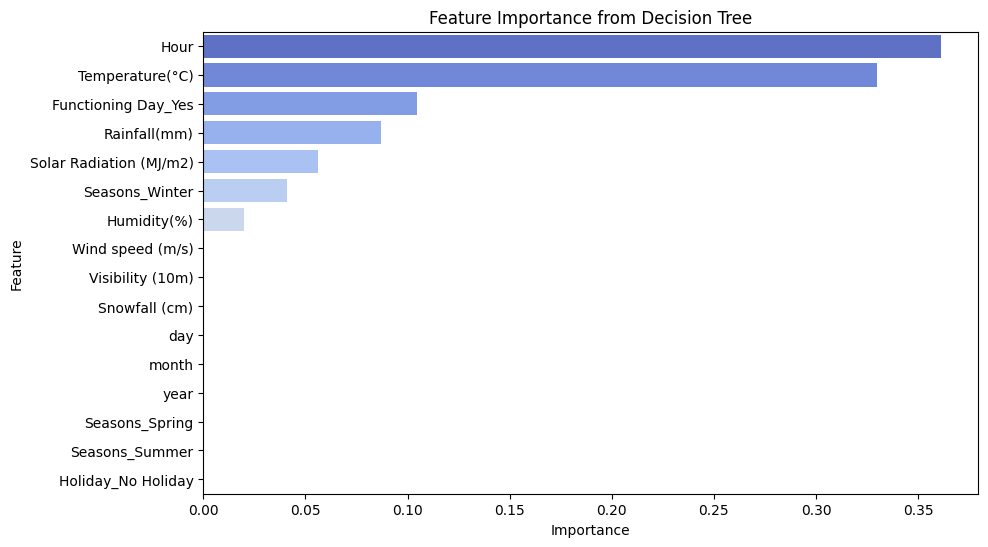

In [32]:
# Extract Feature Importance
feature_importance = modelTree.feature_importances_

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.title('Feature Importance from Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


### Random Forest Regressor

c:\Users\jaime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jaime\AppData\Local\Temp\ipykernel_18948\413004153.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='coolwarm')


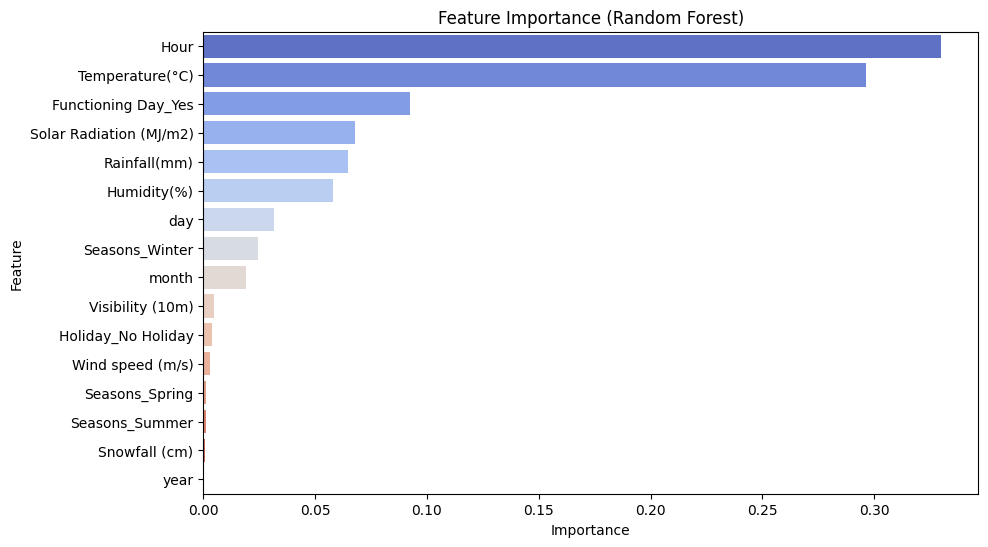

In [22]:

# Train a Random Forest Regressor
modelRandomForest = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
modelRandomForest.fit(X_train, y_train)

# Get feature importances
importancesRandomForest = modelRandomForest.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importancesRandomForest})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='coolwarm')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Predict on the test set
y_pred_random_forest = modelRandomForest.predict(X_test)
    
# Calculate MSE
mse = mean_squared_error(y_test, y_pred_random_forest)

# Store the result
results['Random Forest Regressor'] = mse


### Neural Network

In [23]:
# Define the model
modelNeuralNetwork = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), name='Hidden_Layer_1'),
    Dense(64, activation='relu', name='Hidden_Layer_2'),
    Dense(64, activation='relu', name='Dense_Layer_2'),
    Dense(1, name='Output_Layer')  # Output layer for regression
])

# Compile the model
modelNeuralNetwork.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model

history = modelNeuralNetwork.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
mse, mae = modelNeuralNetwork.evaluate(X_test, y_test)

results['Neural Network'] = mse


c:\Users\jaime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 - mae: 0.0348


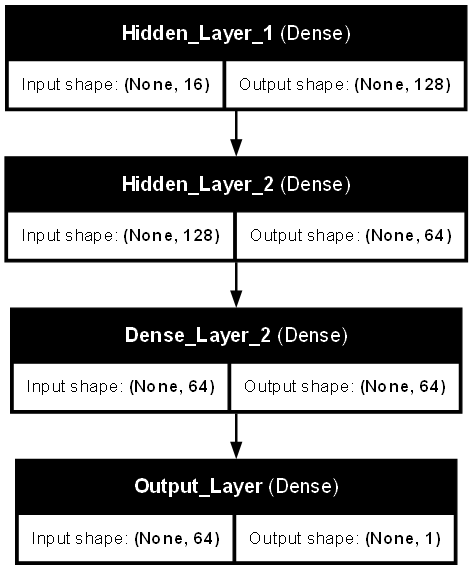

In [24]:

# Assuming `model` is your defined neural network
plot_model(modelNeuralNetwork, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, dpi=90)

### MSE Comparative Table

In [25]:
results_df = pd.DataFrame(list(results.items()), columns=["Model", "MSE"])
results_df.sort_values(by='MSE', ascending=False, inplace=True)
print(results_df)

                     Model       MSE
0        Linear Regression  0.015348
1            Decision Tree  0.011056
2  Random Forest Regressor  0.003336
3           Neural Network  0.003300
